<h1 align="center">MSIN0114: Business Analytics Consulting Project/Dissertation</h1>

<h3 align="center">Web Scrapping for Asana Review on g2.com and trustradius.com</h3>
<br>

 <h3 align="center">Jun 2021</h3>
 <h3 align="center">Github repository:</h3>

<h3>Table of Contents</h3>

* [1. Web Scrapping for Asana](#1.-Web-Scrapping-for-Asana)
* [2. Load Scrapped Data](#2.-Load-Scrapped-Data)
* [3. Initial Cleaning of Dataset](#3.-Initial-Cleaning-of-Dataset)
* [4. Upload Data into PostgreSQL Database](#4.-Upload-Data-into-PostgreSQL-Database) 
* [5. Save Dataset as csv for Local Access](#5.-Save-Dataset-as-csv-for-Local-Access)


In [1]:
# Basic packages 
import numpy as np                   
import pandas as pd              
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt    
import seaborn as sns

import plotly.express as px

# RDS Database Connection 
import psycopg2


## 1. Web Scrapping for Asana

Web Scrapping code for Asana stored as spider_3.py and spider_4.py

In [2]:
!python Spider_3.py

1 {'Name': 'Janhavi R', 'Position': 'Marketing Analyst', 'Company': 'Mid-Market (51-1000 emp.)', 'Rating': 'stars-9', 'Date': 'Apr 29, 2021', 'Title': '"Asana as a Project Management tool"', 'Review': 'What do you like best? It has groups and categories to divide your different projects, and it allows you to collaborate with your team members on various projects. My boss knows what projects I am working on and what projects I have completed. I also like that I can customize my dashboard and my tasks.  Review collected by and hosted on G2.com. What do you dislike? There is nothing that comes to my mind right now that I dislike about Asana. Everything about the tool is excellent, and I will recommend it to all those who need a tool for project and product management.  Review collected by and hosted on G2.com. Recommendations to others considering the product: Asana is a great project and product management tool. It is easy to use. Looks very fun and young. It has a good user interface. T

Traceback (most recent call last):
  File "Spider_3.py", line 80, in <module>
    parse_1(t)
  File "Spider_3.py", line 46, in parse_1
    print(count, p_review)
UnicodeEncodeError: 'gbk' codec can't encode character '\xb4' in position 523: illegal multibyte sequence


7 {'Name': 'Douglas T', 'Position': 'Digital Analyst', 'Company': 'Small-Business (50 or fewer emp.)', 'Rating': 'stars-9', 'Date': 'Apr 30, 2021', 'Title': '"Asana Managing Long Term Projects for big Client at Sweden."', 'Review': 'What do you like best? I like it can be simple to admin the tasks as well as to admin tasks assigned to others. I like that we can create monthly reports to see how much we have done in terms of a "tag" or "section", for us is important to keep the records and to create reports. For this purpose we have the option to download a CSV even if we are free users.  Review collected by and hosted on G2.com. What do you dislike? I also disliked the daily messages or notification sent to my email would not say I like its free version, which is pretty limited. We previously used premium, but license expired, and we were downgraded to free version automatically, we felt the change specially in how much users we could add to the project, but I mean, that is not the end

In [3]:
!python Spider_4.py

1 {'Name': 'Norman Hazlewood', 'Position': 'IT Manager', 'Company': 'Program Development ,  51-200 employees', 'Rating': '8', 'Date': 'May 17, 2021', 'Title': 'Asana is the perfect tool to help small teams become efficient and effective.', 'Review': {'Use Cases and Deployment Scope': '[Asana] is being used specifically for Project Management, Task Management and Vendor Management. It is used across the entire organization in different segments. It addresses the scheduling, tracking and management of activities for major projects. In terms of vendor management and repetitive tasks it is used as a reminder for expiration of licenses, renewals and other relevant tasks that cannot be allowed to fall through the cracks.', 'Pros and Cons': 'Task Management - Being able to assign resources and time lines to specific activitiesProject Management - Being able to plan, execute and track project process using this toolCustomizability - Being able to customize a solution that meets your needs or a

Traceback (most recent call last):
  File "Spider_4.py", line 90, in <module>
    parse_2(t)
  File "Spider_4.py", line 53, in parse_2
    print(count, p_review)
UnicodeEncodeError: 'gbk' codec can't encode character '\U0001f48e' in position 251: illegal multibyte sequence


10 {'Name': 'Andrew Makar', 'Position': 'Program Manager', 'Company': 'Information Technology and Services ,  1-10 employees', 'Rating': '8', 'Date': 'April 01, 2021', 'Title': 'Asana : Blazingly Fast Task Management', 'Review': {'Use Cases and Deployment Scope': 'I have helped organizations and entrepreneurs implement Asana as a case management and personal productivity tool.In some smaller companies, everyone uses the tool to help with collaboration, task management and actual ownership of key activities.The transparency Asana provides is particularly helpful as you can see where specific tasks rank within assigned resources.Since Asana allows you to maintain your own personal task list and collaborate with other team members, it is a useful tool for collaboration across distributed teams.', 'Pros and Cons': 'Asana is a blazingly fast collaborative task list that supports multiple projects. Multiple team members can generate and prioritize tasks for the same project in real-time. Ind

## 2. Load Scrapped Data

In [4]:
# import monday data
g2_Asana= pd.read_excel ('./html_data/Asana/Asana_g2.xls',index_col=0)
tr_Asana=pd.read_excel('./html_data/Asana/Asana_tr.xls',index_col=0)


## 3. Initial Cleaning of Dataset

Initial Cleaning of dataset is required before the data is stored in a PostgreSQL database. This is to ensure the data matches the desired data type specified in the Schema Customer Review

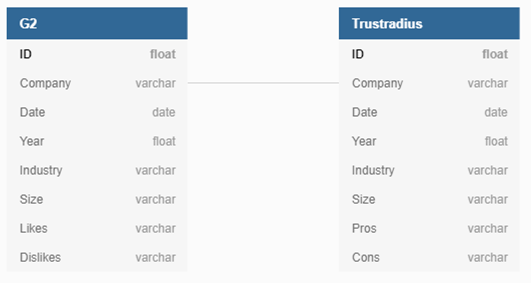

In [5]:
# Extract size from Column Company

g2_Asana['size'] = g2_Asana.Company.str.extract('(\d+)')


# Replace data with no value as missing t
g2_Asana.loc[g2_Asana['size'].isnull(), 'size'] = -1
g2_Asana['size']=g2_Asana['size'].astype('int')

# Categorise the size according the definition provided by G2.com 
g2_Asana['Size'] = g2_Asana['size'].apply(lambda x: 
                              'Med-Market' if x in range(51,1000) else 
                              'Small-Business' if x in range(0,51) else 
                              'Missing' if x==-1 else
                              'Enterprise' )
# Drop repeated columns 

g2_Asana[['Pros', 'Cons','Recommendation','Problem']] = g2_Asana['Review'].str.split('Review collected by and hosted on G2.com', 3, expand=True)
g2_Asana.drop(columns = ['size','Company','Rating','Title','Review','Recommendation','Problem','Name'],inplace = True)

# Rename columns to matches names in Schema
g2_Asana.rename(columns ={'Position':'Industry',
                    'Company':'Size'},inplace = True)

# Create column ID and Company 
g2_Asana.reset_index(drop = True, inplace =True)
g2_Asana['Company'] = 'Asana'
g2_Asana['ID'] = 'G2_'+ g2_Asana['Company']+ '_' +g2_Asana.index.astype(str)

# Extract year from column Date for column Year 
g2_Asana['Date']=pd.to_datetime(g2_Asana['Date'])
g2_Asana['Year'] = g2_Asana['Date'].dt.year.astype(str)

In [6]:
g2_Asana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2497 entries, 0 to 2496
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Industry  1495 non-null   object        
 1   Date      2497 non-null   datetime64[ns]
 2   Size      2497 non-null   object        
 3   Pros      2490 non-null   object        
 4   Cons      2490 non-null   object        
 5   Company   2497 non-null   object        
 6   ID        2497 non-null   object        
 7   Year      2497 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 156.2+ KB


A total of 2497 reviews are collected from g2 for monday.com, https://www.g2.com/products/asana/reviews[].

In [7]:
# Extract the size of the column from the industry column 
# Small-Business: 50 or fewer emp
# Mid-market: 51-1000 emp
# Enterprise: >1000 emp 
tr_Asana.fillna('Missing',inplace = True )
tr_Asana['size1'] = tr_Asana.Company.str.extract('(-\d+)')
tr_Asana['size2'] = tr_Asana.size1.str.extract('(\d+)')
tr_Asana['size2'] = tr_Asana['size2'].fillna(0)
tr_Asana['size0'] = tr_Asana.Company.str.extract('(\d+,\d+)')
tr_Asana['size'] = np.where(tr_Asana.size2 == 0,tr_Asana.size0,tr_Asana.size2)
tr_Asana.loc[tr_Asana['size'].isnull(), 'size'] = -1
tr_Asana.drop(['size1','size2','size0'], axis=1, inplace=True)
tr_Asana['size'] = np.where(tr_Asana['size'] == '10,001',10001,tr_Asana['size'])
tr_Asana['size']=tr_Asana['size'].astype('int')

# Categorise the size according the definition provided by G2.com 
tr_Asana['Size'] = tr_Asana['size'].apply(lambda x: 
                              'Med-Market' if x in range(51,1000) else 
                              'Small-Business' if x in range(0,51) else 
                              'Missing' if x==-1 else
                              'Enterprise' )

tr_Asana.drop(['size'],axis = 1, inplace = True)\


# Remove the nunber of employees information from the industry column 
tr_Asana[['Industry', 'Number of employees']] = tr_Asana['Company'].str.split(',', 1, expand=True)


# Drop repeated columns 
tr_Asana.drop(columns = ['Company','Name','Position','Rating','Title','Number of employees','Review_Use Cases and Deployment Scope',],inplace = True)

# Create column ID and Company 
tr_Asana.reset_index(drop = True, inplace =True)
tr_Asana['Company'] = 'Asana'
tr_Asana['ID'] = 'TR_'+ tr_Asana['Company']+ '_' +tr_Asana.index.astype(str)

# Extract year from column Date for column Year 
tr_Asana['Date']=pd.to_datetime(tr_Asana['Date'])
tr_Asana['Year'] = tr_Asana['Date'].dt.year.astype(str)


In [8]:
tr_Asana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      163 non-null    datetime64[ns]
 1   Pros      163 non-null    object        
 2   Cons      163 non-null    object        
 3   Size      163 non-null    object        
 4   Industry  163 non-null    object        
 5   Company   163 non-null    object        
 6   ID        163 non-null    object        
 7   Year      163 non-null    object        
dtypes: datetime64[ns](1), object(7)
memory usage: 10.3+ KB


In [9]:
g2_Asana.head()

,Industry,Date,Size,Pros,Cons,Company,ID,Year
0,Marketing Analyst,2021-04-29,Med-Market,What do you like best? It has groups and categ...,. What do you dislike? There is nothing that c...,Asana,G2_Asana_0,2021
1,Technical Specialist,2021-05-18,Small-Business,What do you like best? It really helps to impr...,. What do you dislike? I think Asana should au...,Asana,G2_Asana_1,2021
2,Marketing Officer,2021-05-14,Med-Market,What do you like best? The excellent part of A...,". What do you dislike? To date, I have complet...",Asana,G2_Asana_2,2021
3,Sr. Marketing Manager,2021-04-26,Enterprise,What do you like best? Easy to coordinate acro...,. What do you dislike? The software is not sup...,Asana,G2_Asana_3,2021
4,Digital Analytics,2021-05-10,Enterprise,What do you like best? Asana is an excellent p...,. What do you dislike? There is nothing that I...,Asana,G2_Asana_4,2021


A total of 163 reviews are collected from Trustradius.com for Asana, https://www.trustradius.com/products/asana/reviews

## 4. Upload Data into PostgreSQL Database

In [17]:
# Enter credential for database 
engine = psycopg2.connect(
    host="database-1.cg80f0qtitmf.eu-west-1.rds.amazonaws.com",
    user="postgres",
    password="chenziyi",
    port=5432
)

In [58]:
cur = engine.cursor()
cur.execute(""" 
     
     
     CREATE SCHEMA IF NOT EXISTS schema_Customer_Review;
     
     CREATE TABLE IF NOT EXISTS schema_Customer_Review.G2 (
      ID varchar PRIMARY KEY,
      Company varchar,
      Date date,
      Year varchar,
      Industry varchar,
      Size varchar,
      Pros varchar,
      Cons varchar);
      
     CREATE TABLE IF NOT EXISTS schema_Customer_Review.Trustradius (
      ID varchar PRIMARY KEY,
      Company varchar,
      Date date,
      Year varchar,
      Industry varchar,
      Size varchar,
      Pros varchar,
      Cons varchar);
      
      """)

print("Table created successfully")

engine.commit()
engine.close()

Table created successfully


In [12]:
# Insert scrapped data into the database 
# Asana for Table g2


cur = engine.cursor()
s ="""INSERT INTO schema_Customer_review.g2(Industry, Date,Size, Pros, Cons, Company, ID, Year) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"""



for index in range(len(g2_Asana)):
    obj = []
    l=[]
    for col in g2_Asana.columns:
        l.append(g2_Asana[col][index])
    obj.append(l)
    cur.executemany(s, obj)
    engine.commit()
    
print("Insert successfully")

engine.close()

Insert successfully


In [16]:
# Insert scrapped data into the database 
# Asana for Table Trustradius


cur = engine.cursor()
s ="""INSERT INTO schema_Customer_review.Trustradius(Date, Pros, Cons, Size, Industry, Company, ID, Year) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"""

print("Insert successfully")

for index in range(len(tr_Asana)):
    obj = []
    l=[]
    for col in tr_Asana.columns:
        l.append(tr_Asana[col][index])
    obj.append(l)


    cur.executemany(s, obj)
    engine.commit()
engine.close()

Insert successfully


In [18]:
TR= pd.read_sql("select * from schema_Customer_review.Trustradius", engine)
engine.close()

In [19]:
TR

,id,company,date,year,industry,size,pros,cons
0,TR_Monday_0,Monday,2021-06-08,2021,Apparel & Fashion,Small-Business,We can push updates and information for design...,The way emails display after being pushed as a...
1,TR_Monday_1,Monday,2021-06-07,2021,Computer Software,Med-Market,VersitileFlexibleEasy-to-use,"Software Integrations, I feel like if we could..."
2,TR_Monday_2,Monday,2021-06-05,2021,Education Management,Med-Market,"Project management of all our past, ongoing, a...","If I recall, there were some sub item areas th..."
3,TR_Monday_3,Monday,2021-05-20,2021,Retail,Small-Business,Notifications - My boards are set up to update...,Biggest Con - Adding seats to monday.comLet me...
4,TR_Monday_4,Monday,2021-05-19,2021,Higher Education,Small-Business,Collaboration. I have never used a platform wh...,Automations. There are a few things I'd like t...
...,...,...,...,...,...,...,...,...
1160,TR_Asana_157,Asana,2014-05-14,2014,Telecommunications Company,Med-Market,It allows you to create Projects and assign ta...,Asana is a great product to use when you're lo...
1161,TR_Asana_158,Asana,2014-01-17,2014,Marketing and Advertising Company,Med-Market,Few clicks to modify / update projects and tas...,Asana worked especially well for tracking task...
1162,TR_Asana_160,Asana,2014-01-25,2014,Financial Services Company,Med-Market,Easy to organize tasks and assign to other peo...,This is a great tool to use for projects that ...
1163,TR_Asana_161,Asana,2014-01-17,2014,Renewables & Environment Company,Small-Business,Sends task reminders.Allows us to establish du...,No


As shown by the query, the data for Asana is added on top of the data for Monday.com, the review for Asana in table Trustradius can be separation using information in column 'Company' and the unique ID assigned.

## 5. Save Dataset as csv for Local Access

In [20]:
# Save as csv for local access 
df_Asana  = pd.concat([g2_Asana,tr_Asana])
df_Asana.info()
df_Asana.to_csv('Asana review.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2660 entries, 0 to 162
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Industry  1658 non-null   object        
 1   Date      2660 non-null   datetime64[ns]
 2   Size      2660 non-null   object        
 3   Pros      2653 non-null   object        
 4   Cons      2653 non-null   object        
 5   Company   2660 non-null   object        
 6   ID        2660 non-null   object        
 7   Year      2660 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 187.0+ KB


In [21]:
df_Asana.head()

,Industry,Date,Size,Pros,Cons,Company,ID,Year
0,Marketing Analyst,2021-04-29,Med-Market,What do you like best? It has groups and categ...,. What do you dislike? There is nothing that c...,Asana,G2_Asana_0,2021
1,Technical Specialist,2021-05-18,Small-Business,What do you like best? It really helps to impr...,. What do you dislike? I think Asana should au...,Asana,G2_Asana_1,2021
2,Marketing Officer,2021-05-14,Med-Market,What do you like best? The excellent part of A...,". What do you dislike? To date, I have complet...",Asana,G2_Asana_2,2021
3,Sr. Marketing Manager,2021-04-26,Enterprise,What do you like best? Easy to coordinate acro...,. What do you dislike? The software is not sup...,Asana,G2_Asana_3,2021
4,Digital Analytics,2021-05-10,Enterprise,What do you like best? Asana is an excellent p...,. What do you dislike? There is nothing that I...,Asana,G2_Asana_4,2021


In total, 2660 reviews are collect for Asana from both g2.com and trustraidus.com